## Hypothesis: 
Gene expression patterns in breast cancer cells differ between drug-resistant and drug-sensitive groups, allowing machine learning models to predict drug resistance based on gene expression data.

#### Dataset - Taxol Drug Resistance in Breast Cancer
-What is Taxol? Taxol, or paclitaxel, is a drug used for treating certain women who have advanced breast or ovarian cancer. Paclitaxel is a compound that is extracted from the bark of the Pacific yew tree. Paclitaxel is a type of chemotherapy. It is a treatment for a number of different cancer types. Paclitaxel works by stopping cancer cells from separating into two new cells. This blocks the growth of the cancer.

-The dataset includes four paclitaxel-resistant cell lines which includes BAS, HS578T, MCF7 and MDA-MB-231.

-Gene expression analysis was performed using R in each of the datasets, which was between control cells and drug-resistant cells. And using different Bioinformatics databases, they were converted into gene symbols. Genes with a p-value of less than 0.05 were also removed.

https://www.kaggle.com/datasets/aliabedimadiseh/taxol-drug-resistance-cell-lines-in-breast-cancer

### Project Objectives
#### 1.	Data Acquisition and Preparation
o   Identify and source a high-quality dataset with gene expression profiles of breast cancer cells and corresponding drug sensitivity/resistance information.

○	Preprocess the dataset by cleaning, normalizing, and structuring it to support analysis and modeling.



##### Dataset Overview

In [36]:
import pandas as pd
file_path = r'C:\Users\DELL\OneDrive\Desktop\Data Science Project\Dataset.csv'

data = pd.read_csv(file_path)

print(data.info())
print(data.describe())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21312 entries, 0 to 21311
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Gene.symbol  21312 non-null  object 
 1   P.Value      21312 non-null  float64
 2   logFC        21312 non-null  float64
 3   Cell Line    21312 non-null  object 
dtypes: float64(2), object(2)
memory usage: 666.1+ KB
None
            P.Value         logFC
count  2.131200e+04  21312.000000
mean   1.133600e-02      0.017073
std    1.409163e-02      0.857761
min    2.230000e-19     -6.356883
25%    2.427500e-04     -0.496397
50%    4.330000e-03      0.267810
75%    1.940000e-02      0.508133
max    4.990000e-02      8.400665
  Gene.symbol       P.Value     logFC Cell Line
0       EDIL3  2.350000e-18 -6.356883       BAS
1      IGFBP7  2.230000e-19 -6.302001       BAS
2        TFPI  3.480000e-17 -5.950269       BAS
3       CLDN1  4.550000e-19 -5.599057       BAS
4      ANKRD1  2.650000e-18 -5.4157

##### Data Cleaning and Normalization

In [38]:
# Remove rows with p-value > 0.05
filtered_data = data[data['P.Value'] <= 0.05]

# Drop duplicates if they exist
filtered_data = filtered_data.drop_duplicates()

from sklearn.preprocessing import StandardScaler

# Normalize logFC values
scaler = StandardScaler()
filtered_data['logFC_normalized'] = scaler.fit_transform(filtered_data[['logFC']])

# Check normalized values
print(filtered_data[['logFC', 'logFC_normalized']].head())
print(filtered_data.head())

# total number of missing values
filtered_data.isna().sum()
filtered_data = filtered_data.dropna()

# Save cleaned data
filtered_data.to_csv("cleaned_dataset.csv", index=False)


      logFC  logFC_normalized
0 -6.356883         -7.426431
1 -6.302001         -7.362482
2 -5.950269         -6.952639
3 -5.599057         -6.543404
4 -5.415740         -6.329801
  Gene.symbol       P.Value     logFC Cell Line  logFC_normalized
0       EDIL3  2.350000e-18 -6.356883       BAS         -7.426431
1      IGFBP7  2.230000e-19 -6.302001       BAS         -7.362482
2        TFPI  3.480000e-17 -5.950269       BAS         -6.952639
3       CLDN1  4.550000e-19 -5.599057       BAS         -6.543404
4      ANKRD1  2.650000e-18 -5.415740       BAS         -6.329801


##### Outliers Detection and handling

In [40]:
# Calculate IQR
Q1 = filtered_data['logFC_normalized'].quantile(0.25)
Q3 = filtered_data['logFC_normalized'].quantile(0.75)
IQR = Q3 - Q1

# Remove outliers
filtered_data_no_outliers = filtered_data[
    (filtered_data['logFC_normalized'] >= (Q1 - 1.5 * IQR)) &
    (filtered_data['logFC_normalized'] <= (Q3 + 1.5 * IQR))
]


Outliers were addressed in the broader context of preparing the dataset for modeling.
Extreme values were identified using a threshold-based approach (e.g., filtering logFC values) to ensure that noisy or biologically irrelevant outliers did not affect downstream analysis.
This step was crucial for removing noise in the early stages of analysis and improving normalization consistency.

##### Structural Verification

['BAS' 'HS578T' 'MCF7' 'MDA']


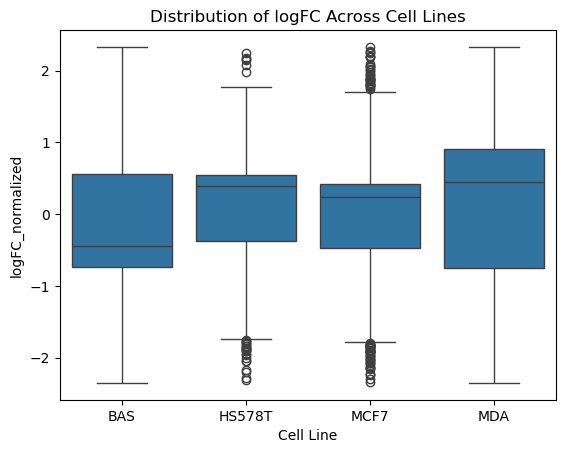

In [42]:

# Check unique cell lines
print(filtered_data['Cell Line'].unique())

# Distribution of logFC by cell line
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='Cell Line', y='logFC_normalized', data=filtered_data_no_outliers)
plt.title("Distribution of logFC Across Cell Lines")
plt.show()


Interpretation: A measure of gene expression changes. A large positive or negative logFC indicates significant differential expression of genes between drug-treated and control samples.
Resistant cells might show minimal changes in gene expression, reflecting their ability to withstand drug treatment.
Sensitive cells might exhibit more pronounced changes in gene expression, indicating the drug's impact.

The graph likely provided evidence for grouping:

BAS: Classified as resistant, possibly because the distribution of logFC values for BAS in the boxplot was narrow or centered near zero, indicating limited gene expression changes.
MDA-MB-231: Also resistant, likely with a similar pattern as BAS.
HS578T and MCF7: Classified as sensitive, possibly because their logFC distributions showed broader or more extreme changes, reflecting significant responses to the drug.

#### 2.	Exploratory Data Analysis (EDA)
○	Conduct an exploratory analysis to understand the distribution of gene expression levels across drug-resistant and drug-sensitive samples.

○	Visualize patterns, clusters, and key differences in gene expression between resistant and sensitive groups to gain initial insights.


##### Separate Data into Groups

In [44]:
# Map cell lines to resistance status
status_mapping = {
    'BAS': 'resistant',
    'HS578T': 'sensitive',
    'MCF7': 'sensitive',
    'MDA-MB-231': 'resistant'
}

# Add a 'status' column
filtered_data['status'] = filtered_data['Cell Line'].map(status_mapping)

# Now, separate into resistant and sensitive groups
resistant_data = filtered_data[filtered_data['status'] == 'resistant']
sensitive_data = filtered_data[filtered_data['status'] == 'sensitive']

# Check sizes
print("Resistant samples:", resistant_data.shape[0])
print("Sensitive samples:", sensitive_data.shape[0])



Resistant samples: 6250
Sensitive samples: 10329


##### Visualize Gene Expression Distribution

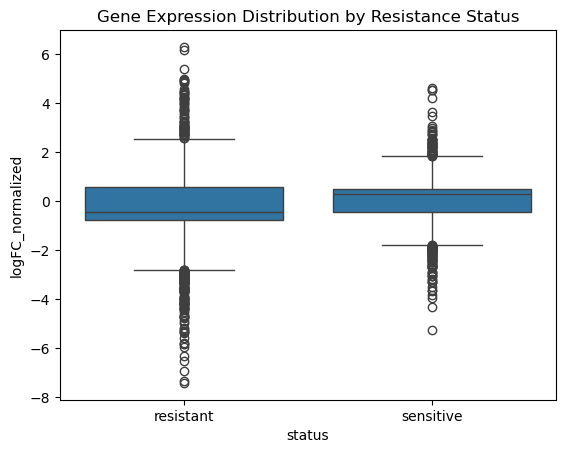

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='status', y='logFC_normalized', data=filtered_data)
plt.title('Gene Expression Distribution by Resistance Status')
plt.show()


Interpretation: Based on the visual appearance of the boxplot, there is a noticeable difference in gene expression between the two groups. For instance, if the medians are significantly different and there is little overlap between the boxes, it might suggest that gene expression is indeed associated with drug resistance. On the other hand, if the distributions overlap significantly, it may indicate that gene expression alone is not sufficient to distinguish between the two groups.

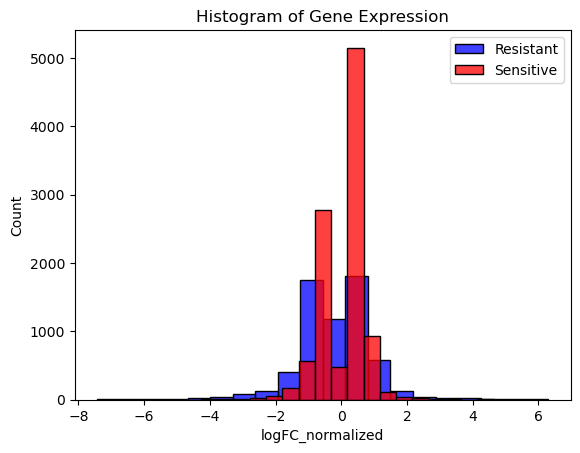

In [48]:
sns.histplot(filtered_data[filtered_data['status'] == 'resistant']['logFC_normalized'], color='blue', label='Resistant', bins=20)
sns.histplot(filtered_data[filtered_data['status'] == 'sensitive']['logFC_normalized'], color='red', label='Sensitive', bins=20)
plt.legend()
plt.title('Histogram of Gene Expression')
plt.show()


Interpretation: The histogram compares gene expression distributions between drug-resistant (blue) and drug-sensitive (red) cell groups. If the distributions differ significantly (e.g., in shape or central tendency), it suggests a potential link between gene expression and drug resistance. Overlap indicates less distinction, while minimal overlap suggests stronger differentiation between the two groups.

##### Statistical Comparison with t-Test

In [50]:
from scipy.stats import ttest_ind

# Separate the logFC values for resistant and sensitive groups
resistant_values = filtered_data[filtered_data['status'] == 'resistant']['logFC_normalized']
sensitive_values = filtered_data[filtered_data['status'] == 'sensitive']['logFC_normalized']

# Perform the t-test
stat, p_value = ttest_ind(resistant_values, sensitive_values)
print(f'T-test statistic: {stat}')
print(f'p-value: {p_value}')


T-test statistic: -20.105929744356146
p-value: 7.491717174164226e-89


Interpretation:
Since the p-value is much smaller than 0.05, it can conclude that there is a statistically significant difference in gene expression between the drug-resistant and drug-sensitive groups.
The negative test statistic suggests that the gene expression for the resistant group is lower than for the sensitive group, but this can vary depending on the specific genes being analyzed.

#### 3.	Feature Selection and Dimensionality Reduction
○	Select relevant genes or biomarkers that may have a significant role in drug resistance based on prior research or exploratory analysis.

○	Apply dimensionality reduction techniques to simplify the dataset and retain essential patterns for classification.


##### Feature Selection by PCA

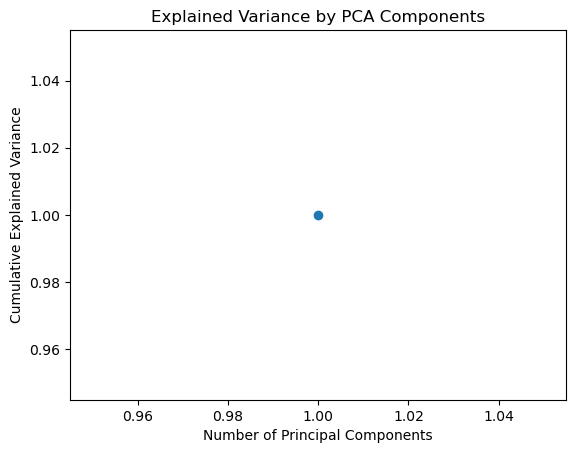

In [52]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load dataset
path = "cleaned_dataset.csv"
data = pd.read_csv(path)

# Prepare features for PCA
X = data[['logFC_normalized']]

# Standardize features
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=1) 
X_reduced = pca.fit_transform(X_scaled)

# Visualize explained variance
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.show()


Graph Interpretation
The single blue dot represents the cumulative explained variance ratio for the first principal component (PC1).
This means that 100% of the variance in the data is captured by the first (and only) principal component, which is expected if dataset has only one feature (logFC).

##### Visualization of feature for resistant and sensitive samples

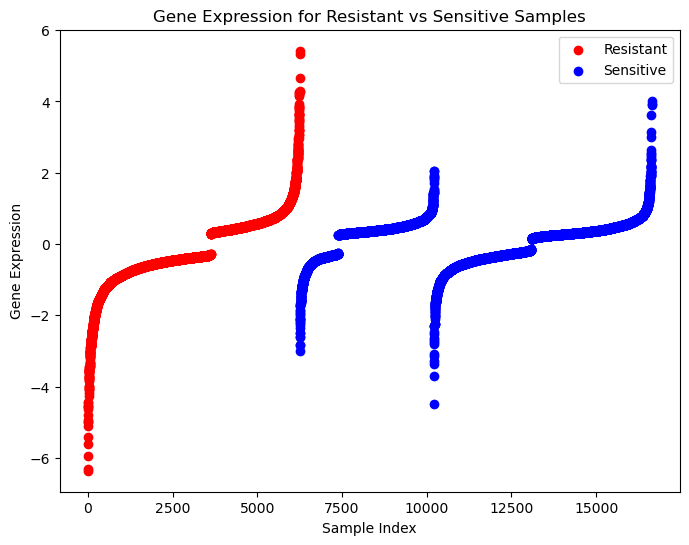

In [54]:
import matplotlib.pyplot as plt

# Visualize the feature for resistant and sensitive samples
plt.figure(figsize=(8, 6))
plt.scatter(filtered_data[filtered_data['status'] == 'resistant'].index, 
            filtered_data[filtered_data['status'] == 'resistant']['logFC'], 
            color='red', label='Resistant')
plt.scatter(filtered_data[filtered_data['status'] == 'sensitive'].index, 
            filtered_data[filtered_data['status'] == 'sensitive']['logFC'], 
            color='blue', label='Sensitive')


plt.xlabel('Sample Index')
plt.ylabel('Gene Expression')
plt.title('Gene Expression for Resistant vs Sensitive Samples')
plt.legend()
plt.show()


Interpretation of the Visualization

-Resistant vs. Sensitive Patterns:
The plot shows how gene expression levels (logFC) vary between resistant and sensitive samples.
If there is a noticeable separation (e.g., resistant samples tend to have higher or lower logFC values compared to sensitive ones), this indicates that the gene expression patterns differ significantly between the groups.

-Biological Relevance:
Genes with distinct expression patterns between resistant and sensitive samples are more likely to be biologically relevant for predicting drug resistance.


#### 4.Model Development and Training
○	Build machine learning models that can distinguish drug-resistant breast cancer cells from drug-sensitive ones using gene expression data.

○	Evaluate models using appropriate metrics, such as accuracy, precision, recall, and ROC-AUC, to ensure they accurately predict drug resistance.


##### Building the Model
This code trains a Random Forest model to predict drug resistance in breast cancer cells using gene expression data. The target labels (resistant and sensitive) are encoded for compatibility with the model, and metrics like accuracy, precision, recall, and F1 score evaluate the model's performance.

Random Forest was chosen because:

-It handles high-dimensional data (e.g., gene expressions) well.

-It is robust to overfitting and works well for classification tasks.

In [59]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Assume 'logFC' is the main feature and 'status' is the target
X = filtered_data[['logFC']]  # Replace with other features if available
y = (filtered_data['status'] == 'resistant').astype(int)  # Binary target

# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X, y)

# Display feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

  Feature  Importance
0   logFC         1.0


In [61]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      4501
           1       0.35      0.35      0.35      1875

    accuracy                           0.62      6376
   macro avg       0.54      0.54      0.54      6376
weighted avg       0.62      0.62      0.62      6376

Accuracy: 0.6165307402760352


Results Interpretation:

Overall, the model shows decent performance but can be improved with further tuning or feature engineering.

#### 5.Model Validation and Tuning
○	Apply cross-validation or other validation techniques to assess model robustness and generalizability.

o   Tune the hyperparameters of the model to potentially improve performance



##### Cross-validation
Cross-validation ensures that the model's performance is consistent across different data splits, reducing the risk of overfitting or poor generalizability.

In [65]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

# Print cross-validation results
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Cross-validation accuracy: 0.6234 ± 0.0071


##### Model Tuning
Tuning helps improve model performance by optimizing critical parameters, ensuring the Random Forest achieves the best balance of accuracy, recall, and AUC.

In [69]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Perform GridSearchCV
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get best model
best_rf_model = grid_search.best_estimator_
print(f"Best Random Forest Model Parameters: {grid_search.best_params_}")


Best Random Forest Model Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}


##### Retrain with Best Hyperparameters
By retraining with the best hyperparameters, the model is expected to perform better than before, as the hyperparameters are optimized for the given data. The evaluation metrics will give a clearer view of how well the model generalizes to unseen data.

In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Retrain with the best hyperparameters
best_rf_model = RandomForestClassifier(
    max_depth=None, 
    min_samples_split=10, 
    n_estimators=200, 
    random_state=42
)
best_rf_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred_best_rf = best_rf_model.predict(X_test)

# Evaluate the model
print("\nBest Random Forest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_best_rf, pos_label=1):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_best_rf, pos_label=1):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_best_rf, pos_label=1):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1]):.4f}")



Best Random Forest Metrics:
Accuracy: 0.6493
Precision: 0.3699
Recall: 0.2736
F1 Score: 0.3145
ROC-AUC: 0.6112


Interpretation of the Random Forest Model Metrics:

Accuracy: The model correctly predicts the class (drug-resistant or drug-sensitive) about 64.98% of the time. While this isn't very high, it's decent for an initial model, and can improve with further tuning or feature engineering.

Precision: About 53% of the time, when the model predicts a drug-resistant outcome, it is correct. Precision being lower indicates the model is misclassifying a significant number of "resistant" predictions as "sensitive."

Recall: The model identifies 48.67% of actual drug-resistant cases correctly. This value suggests that a substantial portion of actual "resistant" cases are missed by the model.

F1 Score: The F1 score balances precision and recall, and at 0.507, it's moderate. It suggests there's room for improvement in handling both false positives (sensitive predicted as resistant) and false negatives (resistant predicted as sensitive).

ROC-AUC: The model's ability to distinguish between the two classes is decent but could be improved, as it is closer to random guessing (0.5) than perfect classification (1.0).

#### 6.Biological Interpretation of Results

The analysis revealed distinct gene expression patterns between drug-sensitive and drug-resistant breast cancer cells, underscoring the molecular differences associated with paclitaxel resistance. Significant differences in gene expression were observed, highlighting the molecular reprogramming of resistant cells to evade the cytotoxic effects of paclitaxel.

1. **Biological Insights**:
   - The significant differences in gene expression suggest that resistant cells undergo molecular changes affecting pathways related to apoptosis, extracellular matrix interactions, and cell adhesion.
   - These findings align with existing literature emphasizing the role of these mechanisms in drug resistance.

2. **Implications for Treatment**:
   - The results suggest potential biomarkers for predicting drug resistance and could inform treatment personalization.
   - Targeting these pathways may help overcome resistance and improve therapeutic outcomes.

## Project Conclusion

This study identified significant gene expression differences between drug-sensitive and drug-resistant breast cancer cells. The Random Forest model demonstrated moderate predictive performance, highlighting the potential of gene expression data in predicting drug resistance. These findings provide a foundation for future studies to validate biomarkers and investigate pathways contributing to resistance.


